Epoch [1/300] | Val Loss: 160.1688 | LR: 0.000500
Epoch [10/300] | Val Loss: 22.8984 | LR: 0.000500
EarlyStopping counter: 1 out of 40
EarlyStopping counter: 2 out of 40
Epoch [20/300] | Val Loss: 11.9257 | LR: 0.000500
EarlyStopping counter: 1 out of 40
EarlyStopping counter: 1 out of 40
EarlyStopping counter: 2 out of 40
EarlyStopping counter: 3 out of 40
Epoch [30/300] | Val Loss: 8.5781 | LR: 0.000500
EarlyStopping counter: 1 out of 40
EarlyStopping counter: 1 out of 40
EarlyStopping counter: 2 out of 40
EarlyStopping counter: 3 out of 40
EarlyStopping counter: 4 out of 40
EarlyStopping counter: 5 out of 40
EarlyStopping counter: 6 out of 40
EarlyStopping counter: 7 out of 40
Epoch [40/300] | Val Loss: 8.7621 | LR: 0.000500
EarlyStopping counter: 8 out of 40
EarlyStopping counter: 1 out of 40
EarlyStopping counter: 1 out of 40
EarlyStopping counter: 2 out of 40
EarlyStopping counter: 3 out of 40
EarlyStopping counter: 4 out of 40
EarlyStopping counter: 5 out of 40
EarlyStopping cou

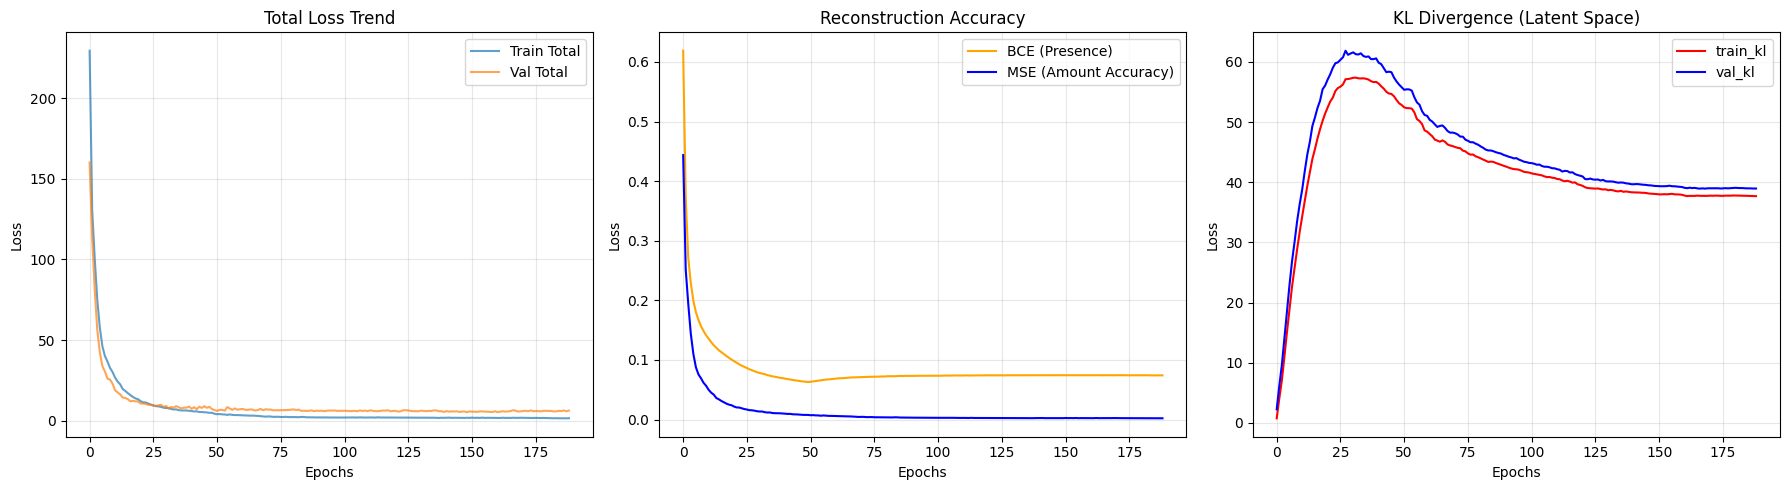

In [1]:
import torch.optim as optim
import matplotlib.pyplot as plt
from vae_earlystopping import EarlyStopping
from model.new_hurdle_model2 import AdvancedHurdleCVAE, advanced_hurdle_loss
import numpy as np
import torch 

# 데이터 로드
train_loader = torch.load('torch/train_loader.pt', weights_only=False)
val_loader = torch.load('torch/val_loader.pt', weights_only=False)
test_loader = torch.load('torch/test_loader.pt', weights_only=False)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# 모델 및 옵티마이저 설정
x_sample, c_sample = next(iter(train_loader))
model = AdvancedHurdleCVAE(x_dim=x_sample.shape[1], c_dim=c_sample.shape[1]).to(device)
optimizer = optim.Adam(model.parameters(), lr=5e-4, weight_decay=1e-5)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=15, factor=0.5)
early_stopping = EarlyStopping(patience=40)

history = {
    'train_total': [], 'val_total': [],  'val_kl':[],
    'train_bce': [], 'train_pos': [], 'train_mse': [], 'train_kl': []
}
epochs = 300
beta_max = 0.05 # KL 정규화를 낮춰 복원 정밀도 확보

for epoch in range(1, epochs + 1):
    model.train()
    t_loss, t_bce, t_pos, t_mse, t_kl = 0, 0, 0, 0, 0
    
    # 이미 잘하는 Sparsity(BCE)보다 수치(Amount)에 집중하도록 alpha를 서서히 낮춤
    current_alpha = 10.0 if epoch < 50 else 1.0 
    beta = min(beta_max, (epoch / (epochs * 0.4)) * beta_max)

    for x, c in train_loader:
        x, c = x.to(device), c.to(device)
        optimizer.zero_grad()
        
        p_logits, mu_log, logvar_log, mu_z, logvar_z = model(x, c)
        # R2 상승을 위해 lambda_mse를 500 정도로 강력하게 부여
        loss_dict = advanced_hurdle_loss(p_logits, mu_log, logvar_log, x, mu_z, logvar_z, 
                                         alpha=current_alpha, beta=beta, lambda_reg=500.0,eps=1e-7)
        if torch.isnan(loss_dict['loss']):
            print("NaN detected in Loss, skipping this batch...")
            continue

        loss_dict['loss'].backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=0.5)
        optimizer.step()
        
        t_loss += loss_dict['loss'].item()
        t_bce += loss_dict['bce'].item()
        t_pos += loss_dict['pos'].item()
        t_kl += loss_dict['kl'].item()
        t_mse += loss_dict['mse'].item()

    # Validation
    model.eval()
    v_loss = 0
    v_kl = 0
    with torch.no_grad():
        for x_v, c_v in val_loader:
            x_v, c_v = x_v.to(device), c_v.to(device)
            p_v, m_v, lv_v, muz_v, logz_v = model(x_v, c_v)
            v_loss_dict = advanced_hurdle_loss(p_v, m_v, lv_v, x_v, muz_v, logz_v, 
                                               alpha=current_alpha, beta=beta, lambda_reg=500.0,eps=1e-7)
            v_loss += v_loss_dict['loss'].item()
            v_kl += v_loss_dict['kl'].item()

    avg_train_loss = t_loss / len(train_loader)
    avg_val_loss = v_loss / len(val_loader)
    avg_val_kl = v_kl/len(val_loader)
    
    # 히스토리 기록
    history['train_total'].append(avg_train_loss)
    history['val_total'].append(avg_val_loss)
    history['val_kl'].append(avg_val_kl)
    history['train_bce'].append(t_bce / len(train_loader))
    history['train_pos'].append(t_pos / len(train_loader))
    history['train_kl'].append(t_kl / len(train_loader))
    history['train_mse'].append(t_mse / len(train_loader))

    scheduler.step(avg_val_loss)
    
    if epoch % 10 == 0 or epoch == 1:
        current_lr = optimizer.param_groups[0]['lr']
        print(f"Epoch [{epoch}/{epochs}] | Val Loss: {avg_val_loss:.4f} | LR: {current_lr:.6f}")

    if early_stopping(avg_val_loss, model):
        print("Early stopping triggered.")
        break

early_stopping.load_best_model(model)

# --- 3. 학습 과정 시각화 (Loss Curves) ---
plt.figure(figsize=(18, 5))

# (1) Total Loss: Train vs Val
plt.subplot(1, 3, 1)
plt.plot(history['train_total'], label='Train Total', alpha=0.7)
plt.plot(history['val_total'], label='Val Total', alpha=0.7)
plt.title('Total Loss Trend')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True, alpha=0.3)

# (2) Reconstruction Breakdown (BCE vs Pos)
plt.subplot(1, 3, 2)
plt.plot(history['train_bce'], label='BCE (Presence)', color='orange')
plt.plot(history['train_mse'], label='MSE (Amount Accuracy)', color='blue') # MSE 추이 추가
plt.title('Reconstruction Accuracy')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid(True, alpha=0.3)

# (3) KL Divergence
plt.subplot(1, 3, 3)
plt.plot(history['train_kl'], label='train_kl', color='red')
plt.plot(history['val_kl'],label = 'val_kl',color = 'blue')
plt.title('KL Divergence (Latent Space)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

Restored best model with loss: 5.263276
StandardScaler 기반 테스트 분석 시작...


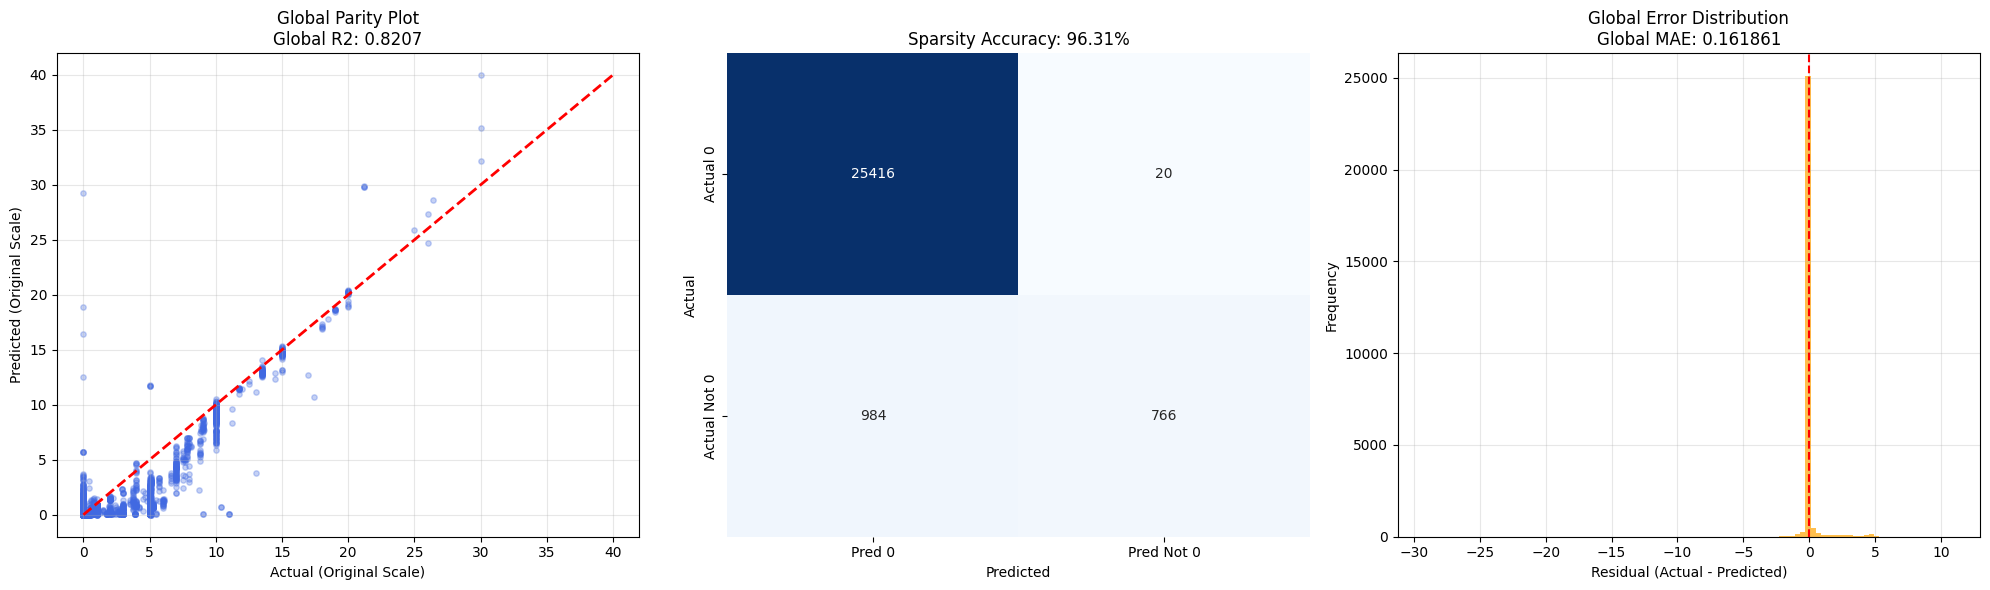

Final Global R2: 0.8207
Final Global MAE: 0.161861


In [4]:
import numpy as np
import torch
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import r2_score, mean_absolute_error, confusion_matrix

# 1) 저장된 StandardScaler 로드
x_scaler = joblib.load('./torch/x_scaler.pkl')
test_loader = torch.load('torch/test_loader_new.pt', weights_only=False)

# 2) 모델 평가 모드
early_stopping.load_best_model(model)
model.eval()

all_x_test_raw = []
all_x_hat_raw = []
all_prob = []

print("StandardScaler 기반 테스트 분석 시작...")

with torch.no_grad():
    for x_t, c_t in test_loader:
        x_t, c_t = x_t.to(device), c_t.to(device)
        
        # 모델 추론 (mu_log, logvar_log는 스케일링된 도메인에서의 로그값)
        p_logits, mu_log, logvar_log, _, _ = model(x_t, c_t)
        prob = torch.sigmoid(p_logits)
        
        # [핵심] 스케일링된 도메인 내에서의 기댓값 복원
        # LogNormal 분포의 평균: exp(mu + 0.5 * sigma^2)
        clamped_var = torch.exp(torch.clamp(logvar_log, min=-7, max=2))
        pred_scaled = torch.exp(mu_log + 0.5 * clamped_var)
        
        # 3) --- 역변환 (StandardScaler Inverse) ---
        # StandardScaler만 적용했으므로 inverse_transform만 수행 (log 역변환 제외)
        pred_raw = x_scaler.inverse_transform(pred_scaled.cpu().numpy())
        actual_raw = x_scaler.inverse_transform(x_t.cpu().numpy())

        # 4) Soft Hurdle 결합 (확률 * 복원된 함량)
        prob_np = prob.cpu().numpy()
        x_hat_final = prob_np * pred_raw
        
        all_x_test_raw.append(actual_raw)
        all_x_hat_raw.append(x_hat_final)
        all_prob.append(prob_np)

# 데이터 평탄화
all_x_test_raw = np.concatenate(all_x_test_raw, axis=0).ravel()
all_x_hat_raw = np.concatenate(all_x_hat_raw, axis=0).ravel()
all_prob = np.concatenate(all_prob, axis=0).ravel()

# 수치적 노이즈 제거 (0 이하 값 방지 및 미세값 처리)
all_x_hat_raw = np.maximum(all_x_hat_raw, 0)
all_x_hat_raw[all_x_hat_raw < 1e-4] = 0

# --- 5) 시각화: Parity, Sparsity, Residual ---
plt.figure(figsize=(20, 6))

# (1) Global Parity Plot
plt.subplot(1, 3, 1)
plt.scatter(all_x_test_raw, all_x_hat_raw, alpha=0.3, s=15, color='royalblue')
limit = max(all_x_test_raw.max(), all_x_hat_raw.max())
plt.plot([0, limit], [0, limit], 'r--', lw=2, label='Ideal')
plt.title(f'Global Parity Plot\nGlobal R2: {r2_score(all_x_test_raw, all_x_hat_raw):.4f}')
plt.xlabel('Actual (Original Scale)')
plt.ylabel('Predicted (Original Scale)')
plt.grid(True, alpha=0.3)

# (2) Sparsity Confusion Matrix
plt.subplot(1, 3, 2)
# 실제 원본 데이터가 1e-5보다 크면 존재한다고 판정
actual_bin = (all_x_test_raw > 1e-5).astype(int)
pred_bin = (all_prob > 0.5).astype(int) 
cm = confusion_matrix(actual_bin, pred_bin)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Pred 0', 'Pred Not 0'], yticklabels=['Actual 0', 'Actual Not 0'])
plt.title(f'Sparsity Accuracy: {(actual_bin == pred_bin).mean()*100:.2f}%')
plt.xlabel('Predicted')
plt.ylabel('Actual')

# (3) Residual Distribution (요청하신 부분)
plt.subplot(1, 3, 3)
# 잔차 계산 (실제값 - 예측값)
residuals = all_x_test_raw - all_x_hat_raw
plt.hist(residuals, bins=100, color='orange', alpha=0.7)
plt.axvline(0, color='red', linestyle='--')
plt.title(f'Global Error Distribution\nGlobal MAE: {mean_absolute_error(all_x_test_raw, all_x_hat_raw):.6f}')
plt.xlabel('Residual (Actual - Predicted)')
plt.ylabel('Frequency')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"Final Global R2: {r2_score(all_x_test_raw, all_x_hat_raw):.4f}")
print(f"Final Global MAE: {mean_absolute_error(all_x_test_raw, all_x_hat_raw):.6f}")

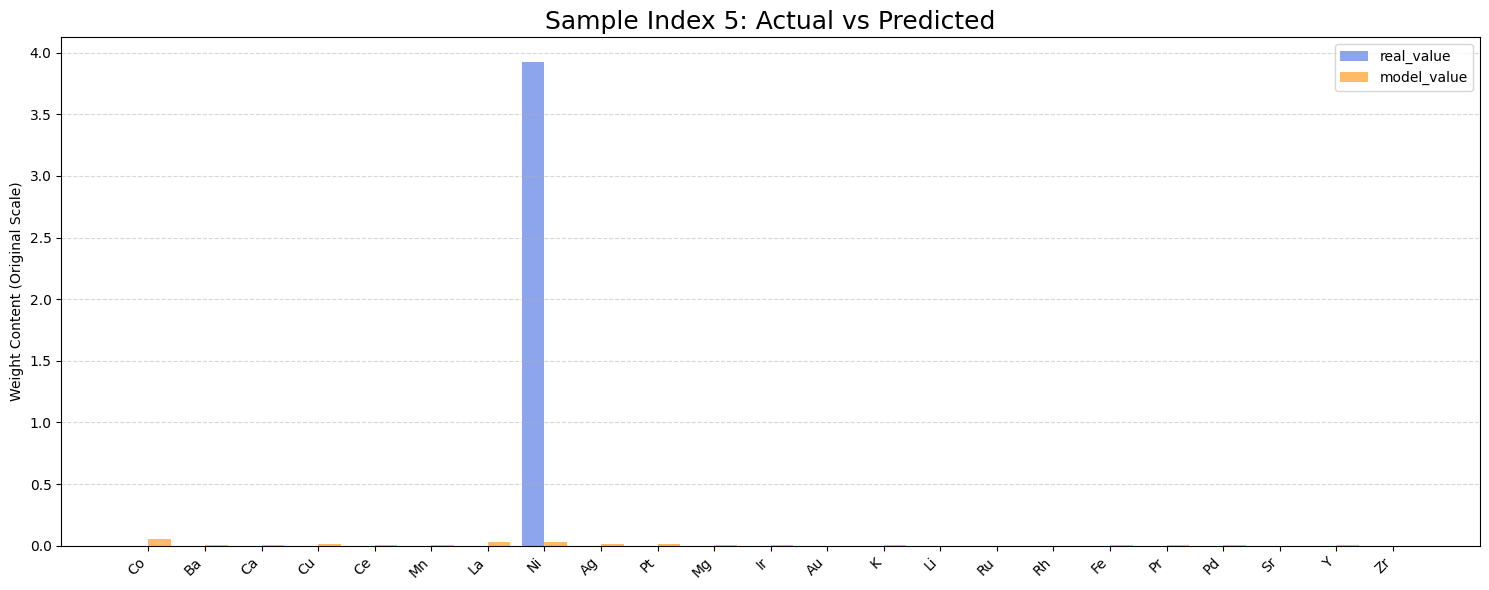

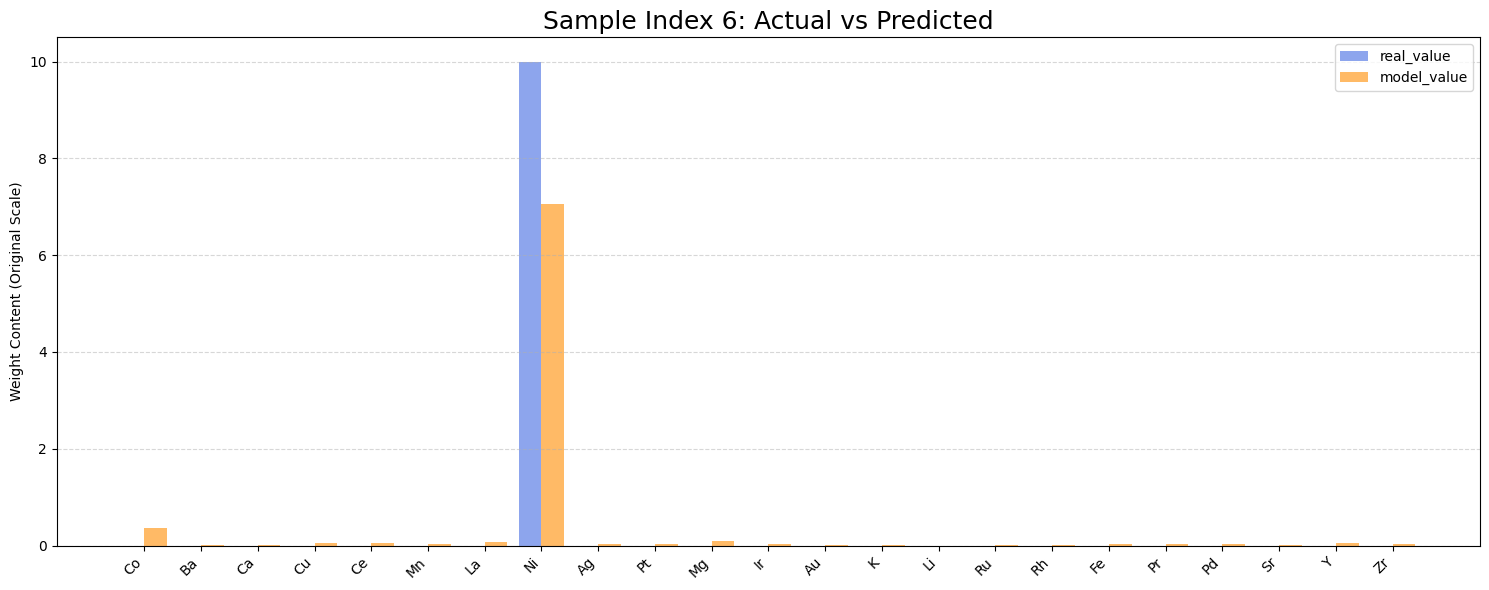

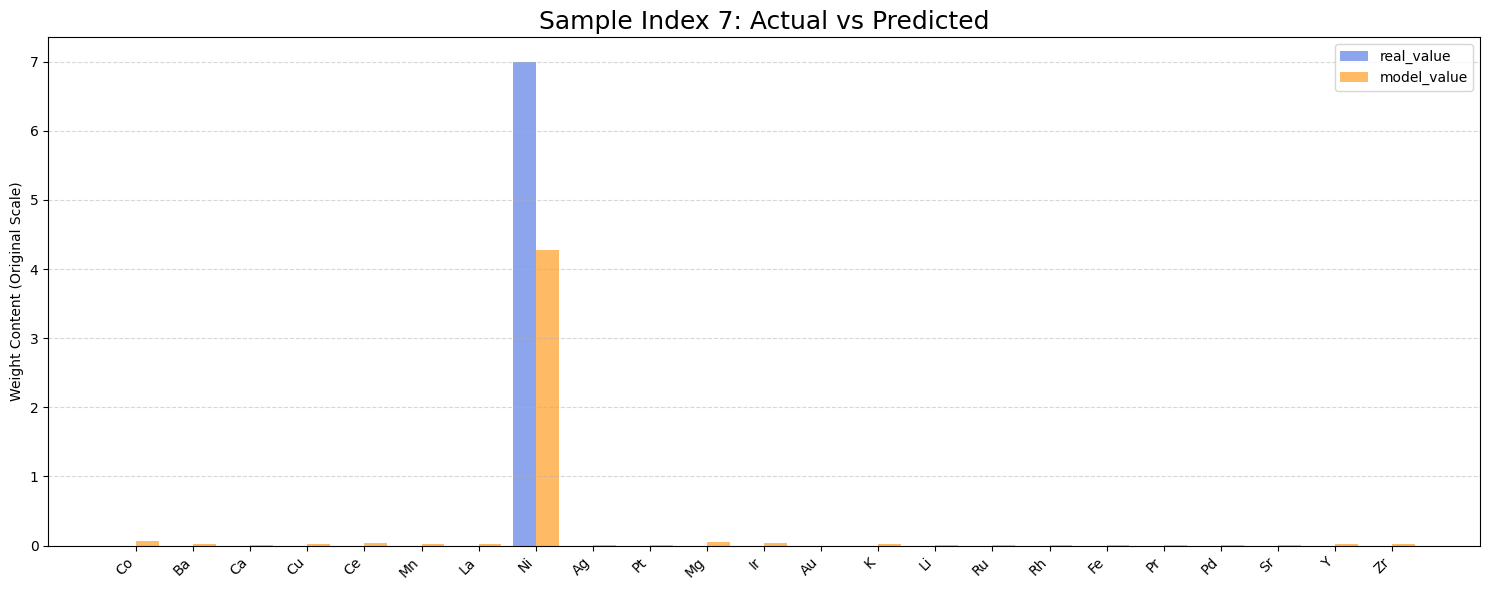

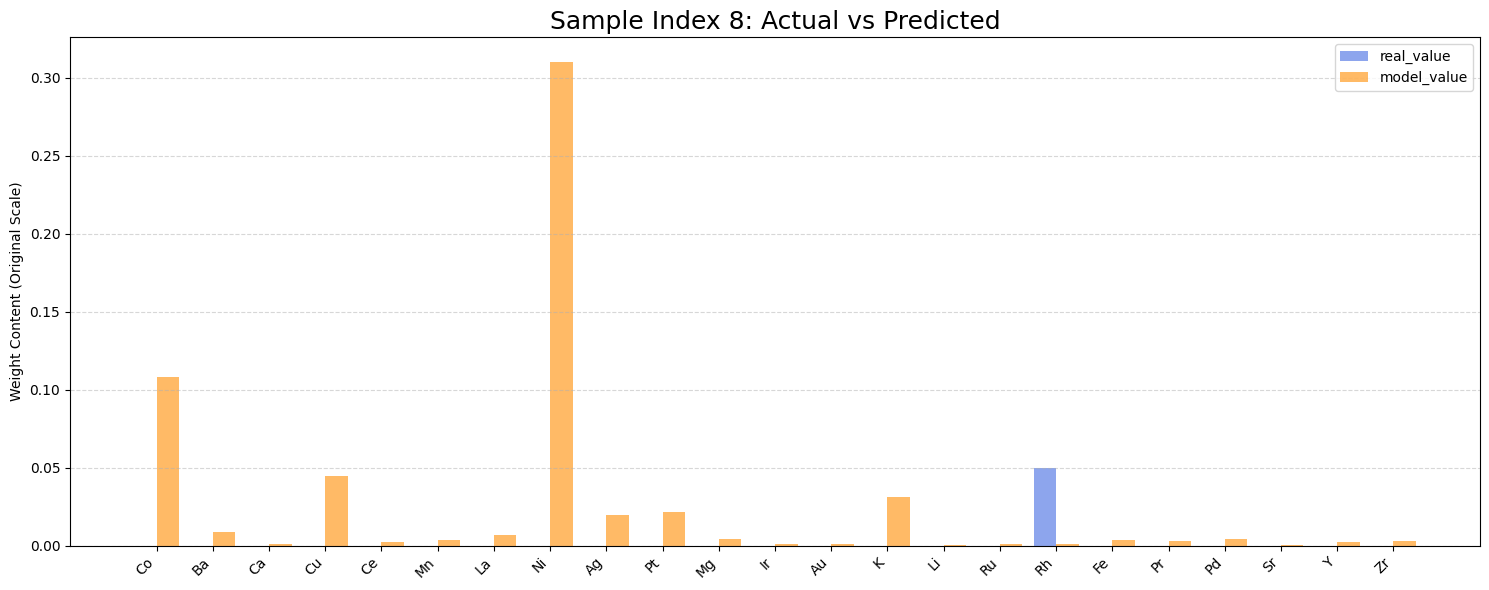

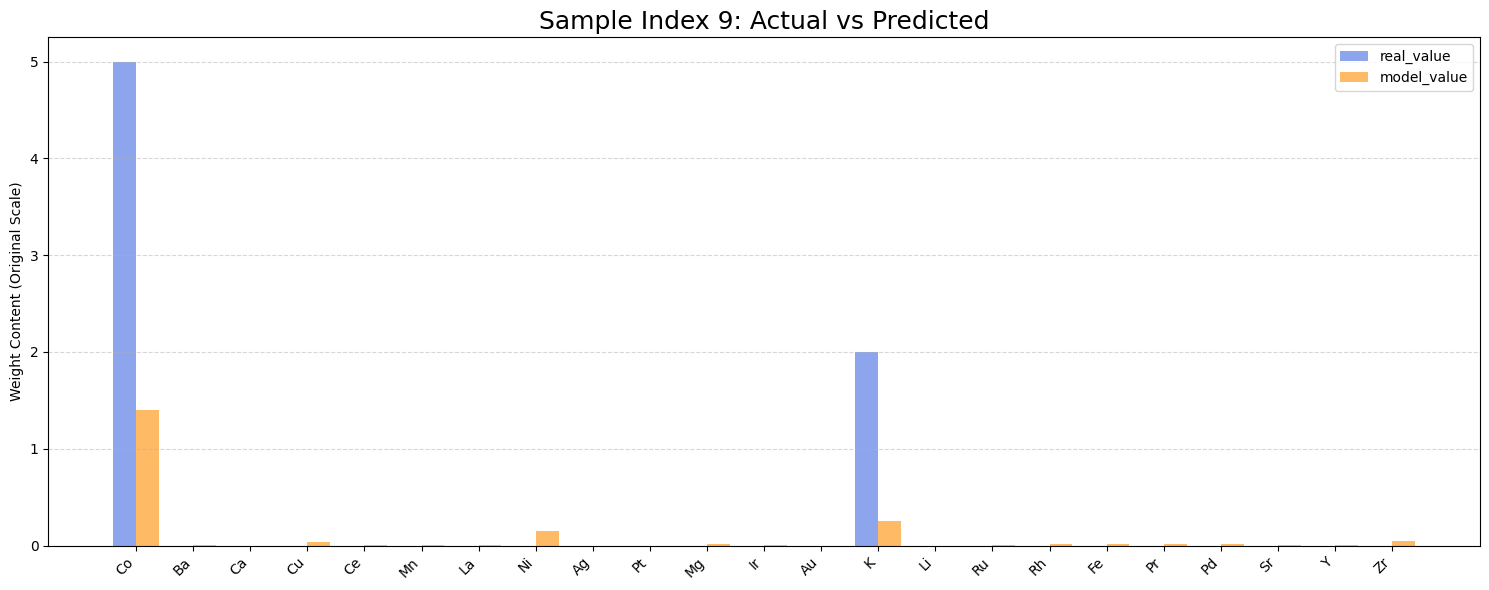

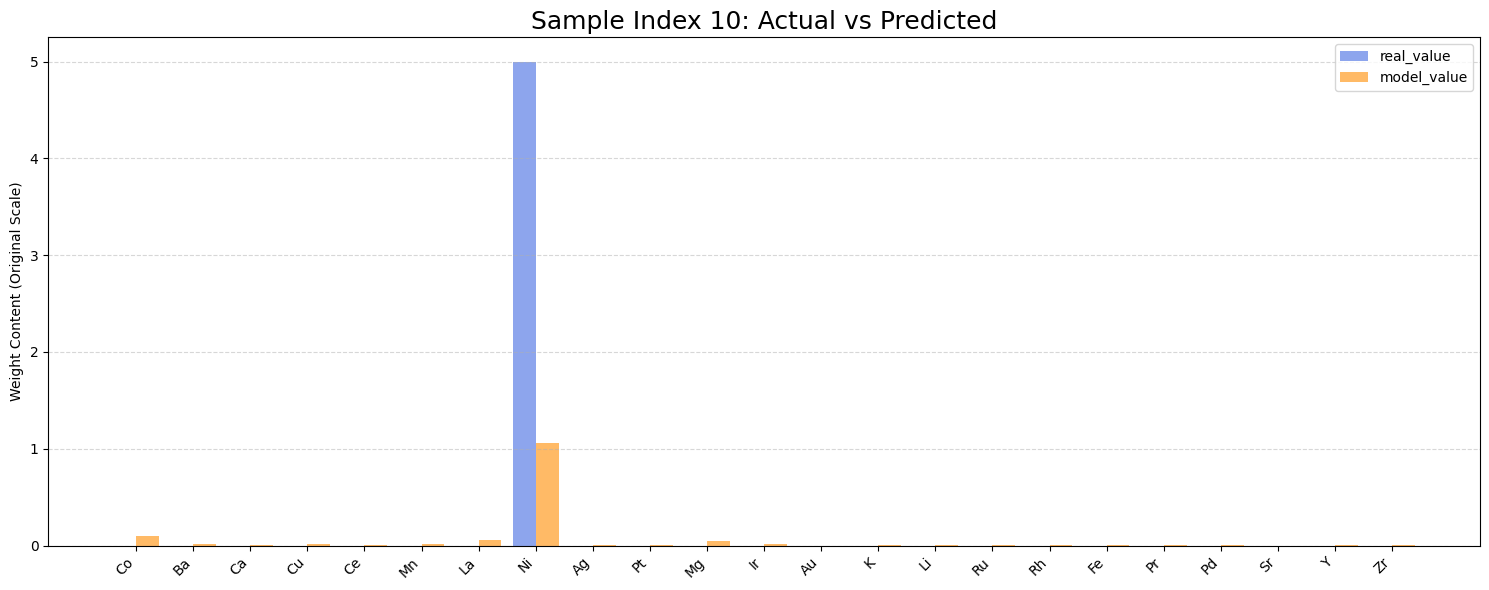

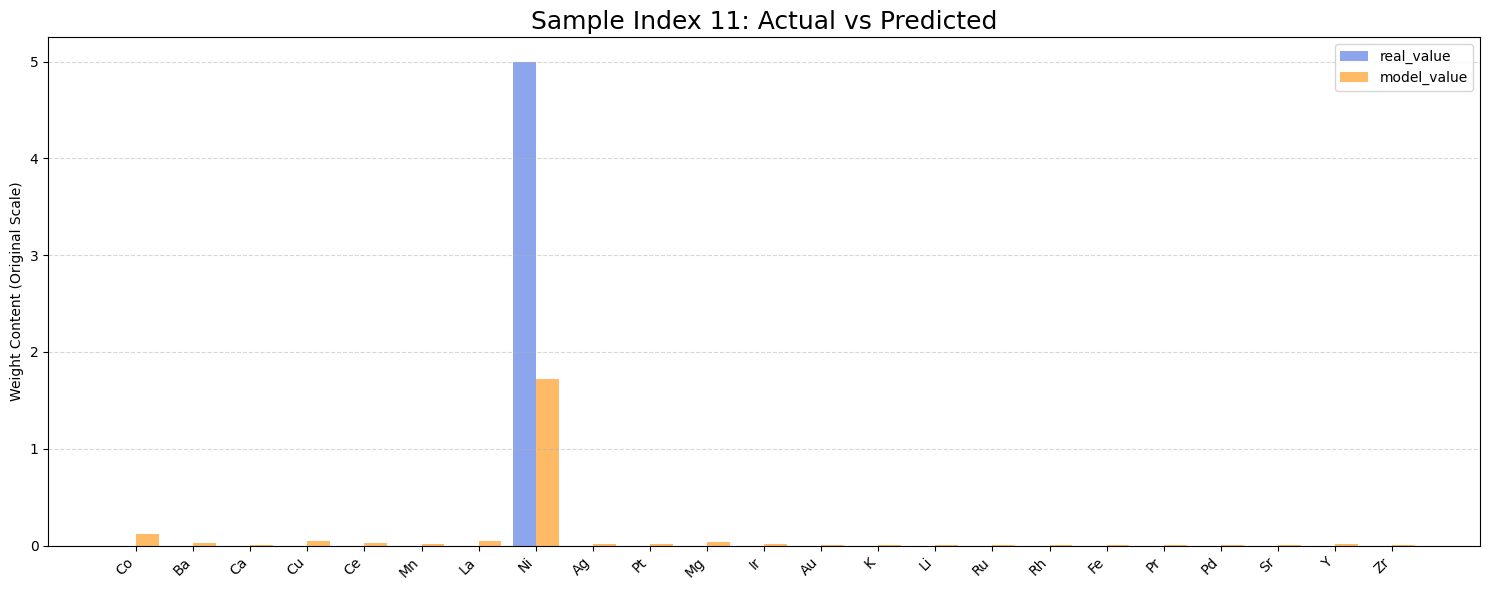

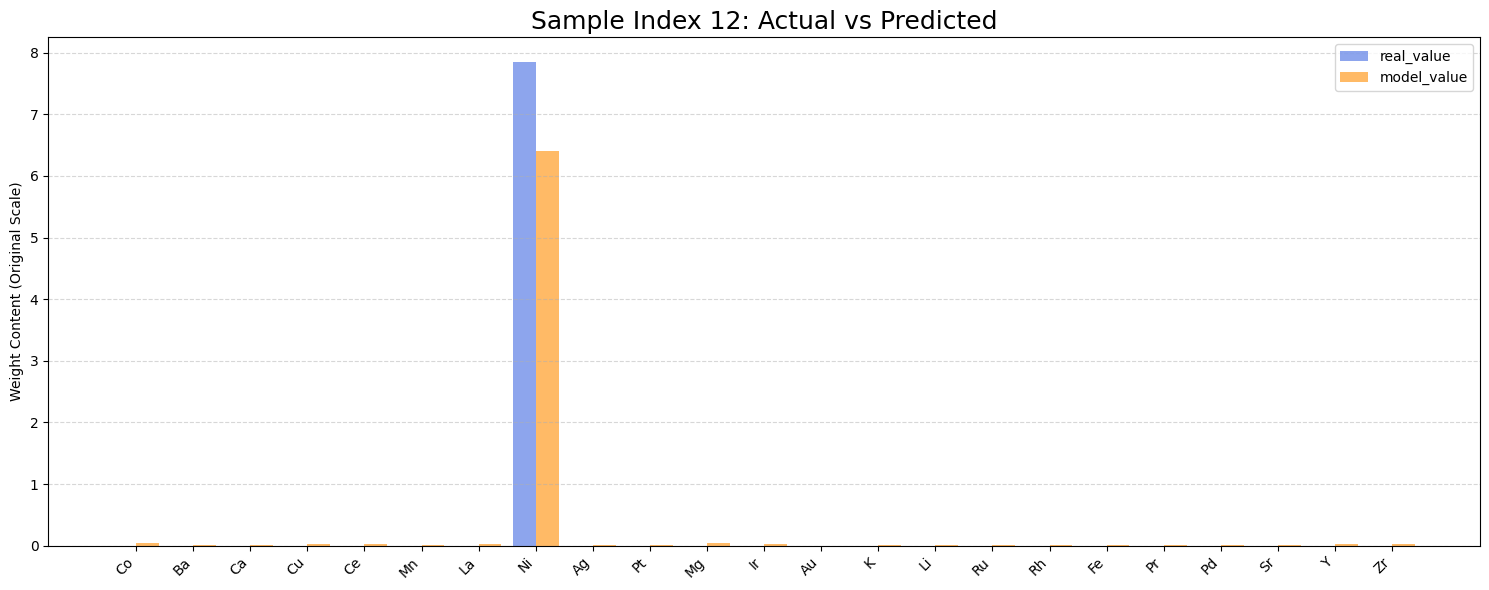

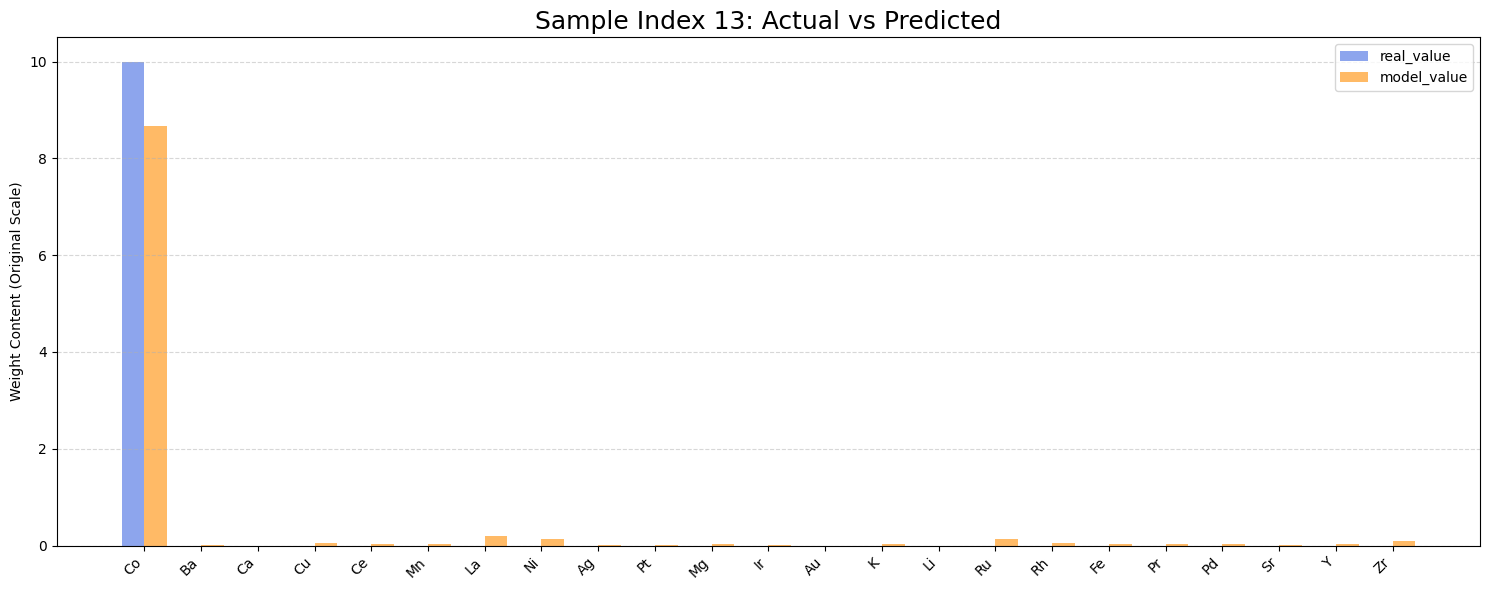

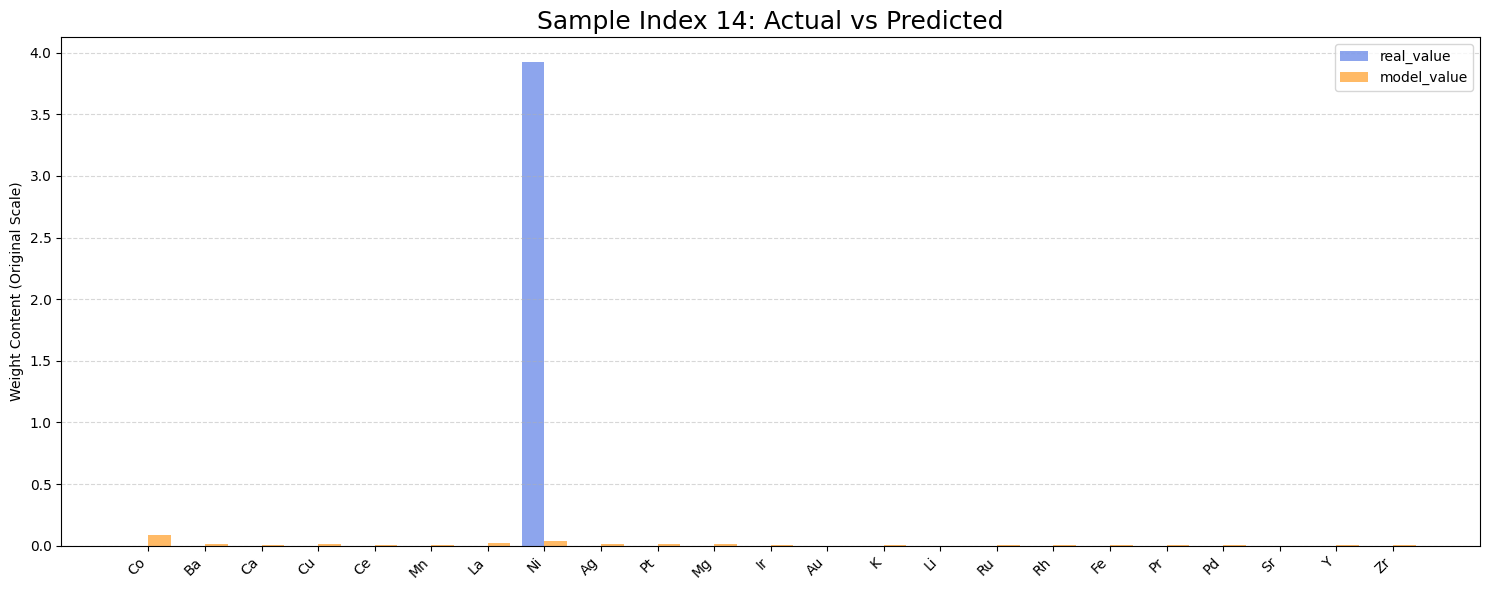


Final RMSE: 0.7278
Final R2: 0.8204


In [3]:
import numpy as np
import torch
import joblib
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score

# 1) 스케일러 및 컬럼명 로드
x_scaler = joblib.load('./torch/x_scaler.pkl')
df_meta = pd.read_csv('211210-DRM-total.csv')
metal_columns = df_meta.iloc[:, 2:25].columns

# 2) 모델 추론 및 2차원 데이터 수집
model.eval()
x_true_raw_list = []
x_hat_raw_list = []

with torch.no_grad():
    for x_t, c_t in test_loader:
        x_t, c_t = x_t.to(device), c_t.to(device)
        
        # 모델 출력 (StandardScaler가 적용된 도메인의 예측값)
        p_logits, mu_log, logvar_log, _, _ = model(x_t, c_t)
        prob = torch.sigmoid(p_logits).cpu().numpy()
        
        # [핵심] StandardScaler 도메인에서의 기댓값 복원
        # Hurdle 모델은 내부적으로 로그 도메인(mu)을 다루므로 exp를 통해 스케일링된 함량을 구함
        clamped_var = torch.exp(torch.clamp(logvar_log, min=-7, max=2))
        pred_scaled = torch.exp(mu_log + 0.5 * clamped_var)
        
        # 3) --- 역변환 (StandardScaler Inverse Only) ---
        # 사용자님 요청대로 expm1 없이 inverse_transform만 수행
        pred_raw = x_scaler.inverse_transform(pred_scaled.cpu().numpy())
        actual_raw = x_scaler.inverse_transform(x_t.cpu().numpy())
        
        # Soft Hurdle 적용 (확률 * 복원된 원본 함량)
        x_hat_sample = prob * pred_raw
        
        x_true_raw_list.append(actual_raw)
        x_hat_raw_list.append(x_hat_sample)

# 4) (샘플 수, 금속 수) 형태의 2차원 행렬로 통합
x_true_test = np.concatenate(x_true_raw_list, axis=0)
x_hat_test = np.concatenate(x_hat_raw_list, axis=0)

# 5) 샘플별 성분 비교 시각화 (인덱스 5번 ~ 14번)
for i in range(5, 15):
    plt.figure(figsize=(15, 6))
    x_axis = np.arange(len(metal_columns))
    width = 0.4
    
    # 실제값(Blue) vs 모델예측값(Orange)
    plt.bar(x_axis - width/2, x_true_test[i], width, label='real_value', color='royalblue', alpha=0.6)
    plt.bar(x_axis + width/2, x_hat_test[i], width, label='model_value', color='darkorange', alpha=0.6)
    
    plt.xticks(x_axis, metal_columns, rotation=45, ha='right')
    plt.title(f'Sample Index {i}: Actual vs Predicted', fontsize=18)
    plt.ylabel('Weight Content (Original Scale)')
    plt.legend()
    plt.grid(axis='y', linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()

# 6) 전체 지표 산출
y_true = x_true_test.flatten()
y_pred = x_hat_test.flatten()
print(f"\nFinal RMSE: {np.sqrt(mean_squared_error(y_true, y_pred)):.4f}")
print(f"Final R2: {r2_score(y_true, y_pred):.4f}")

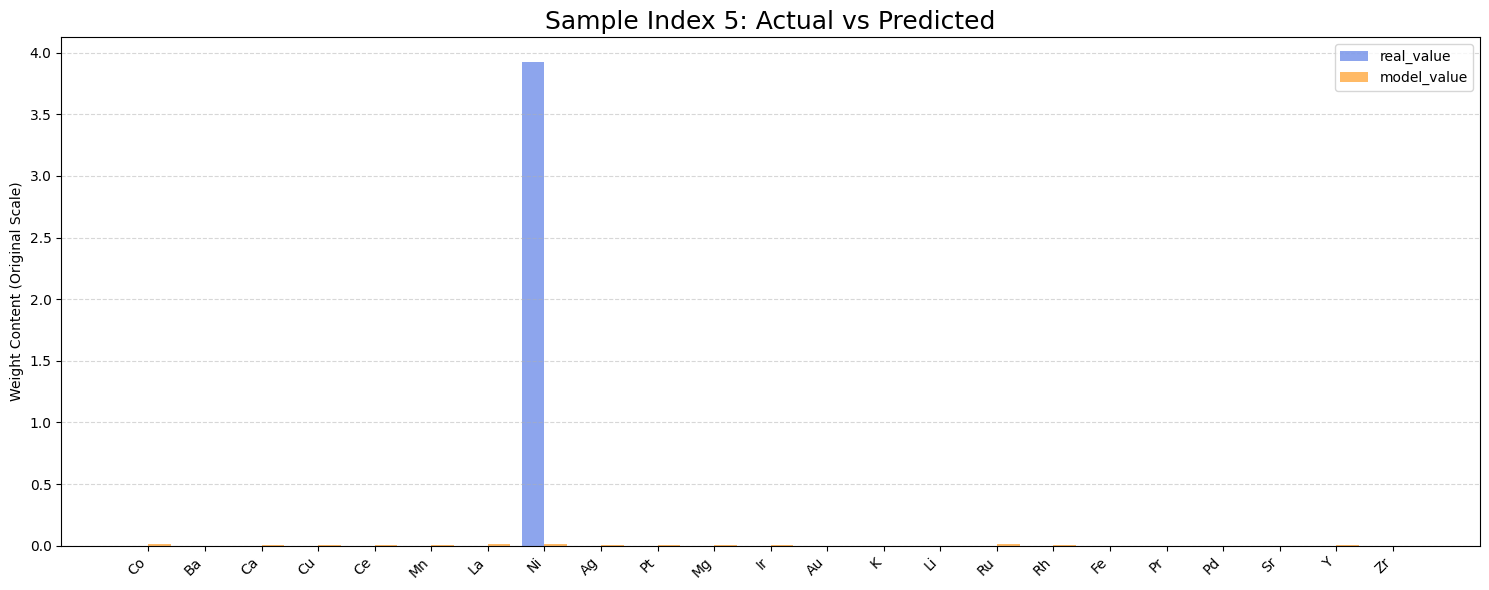

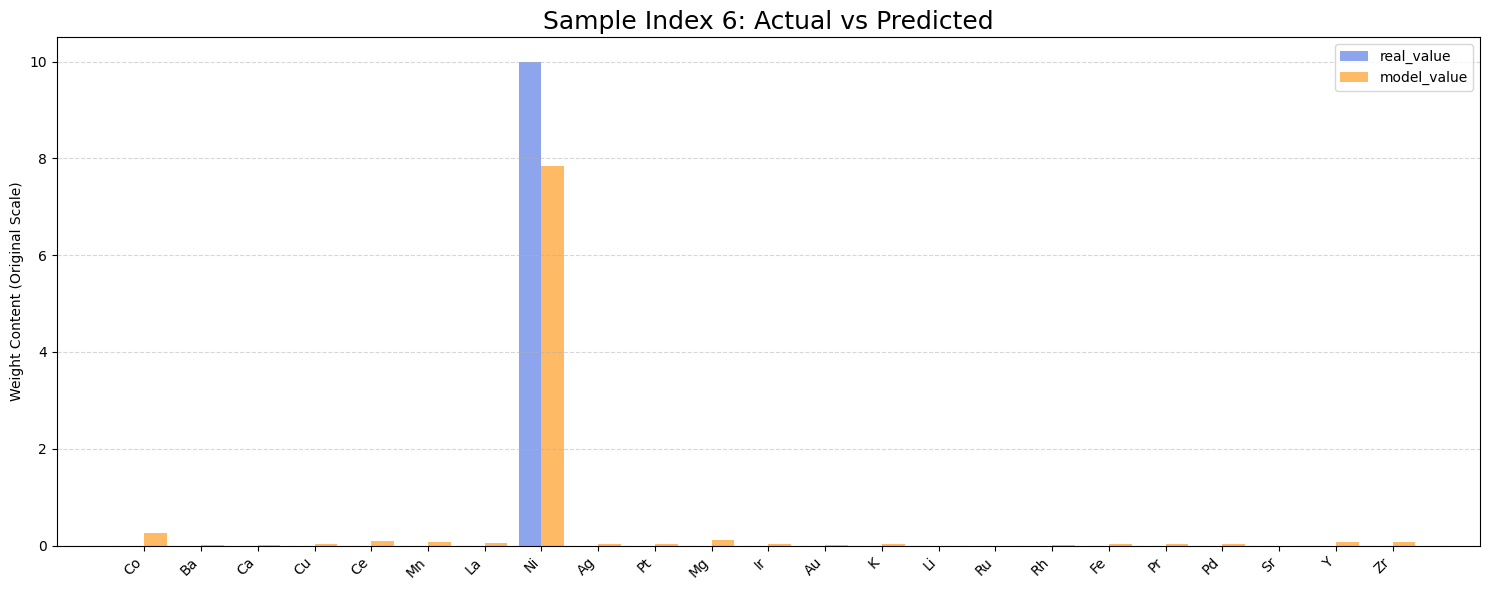

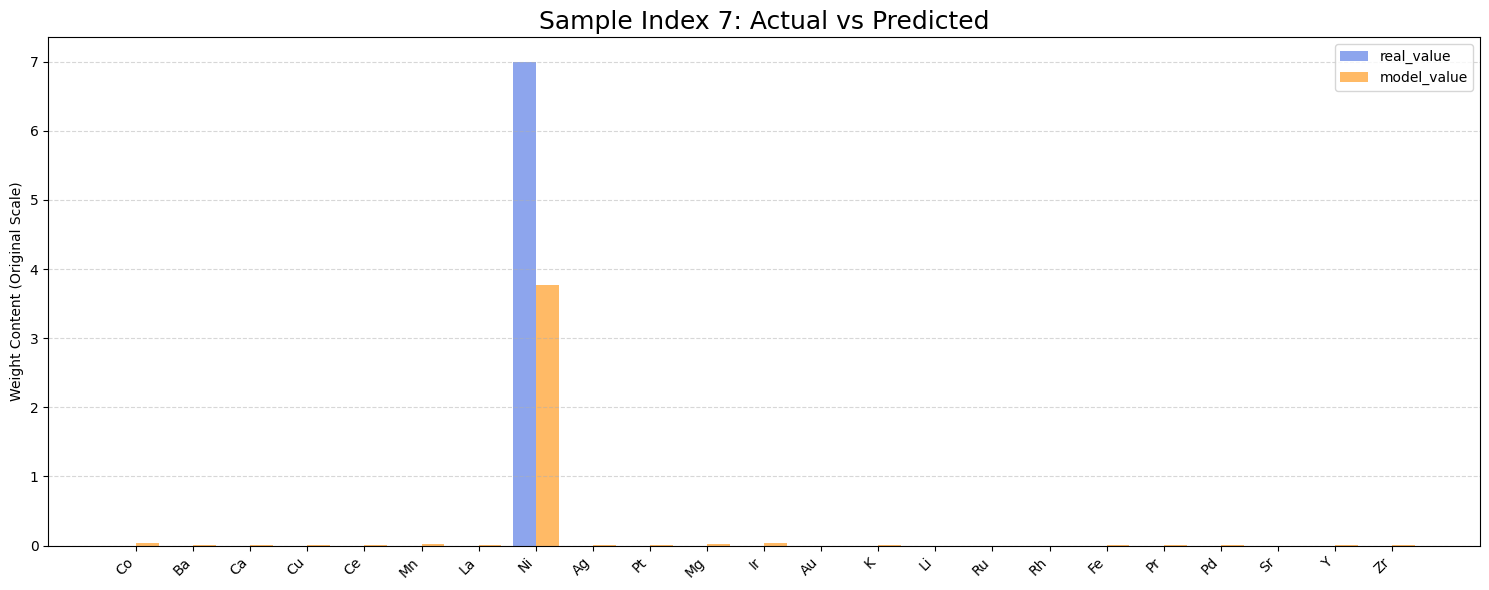

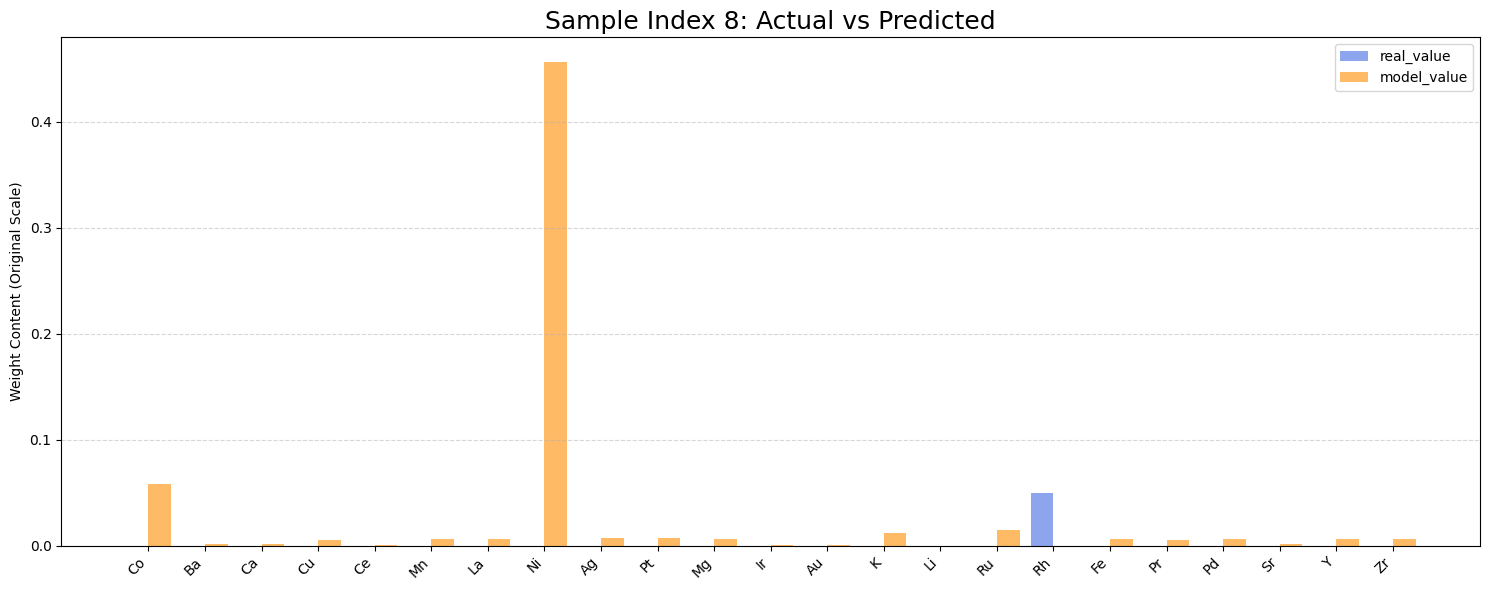

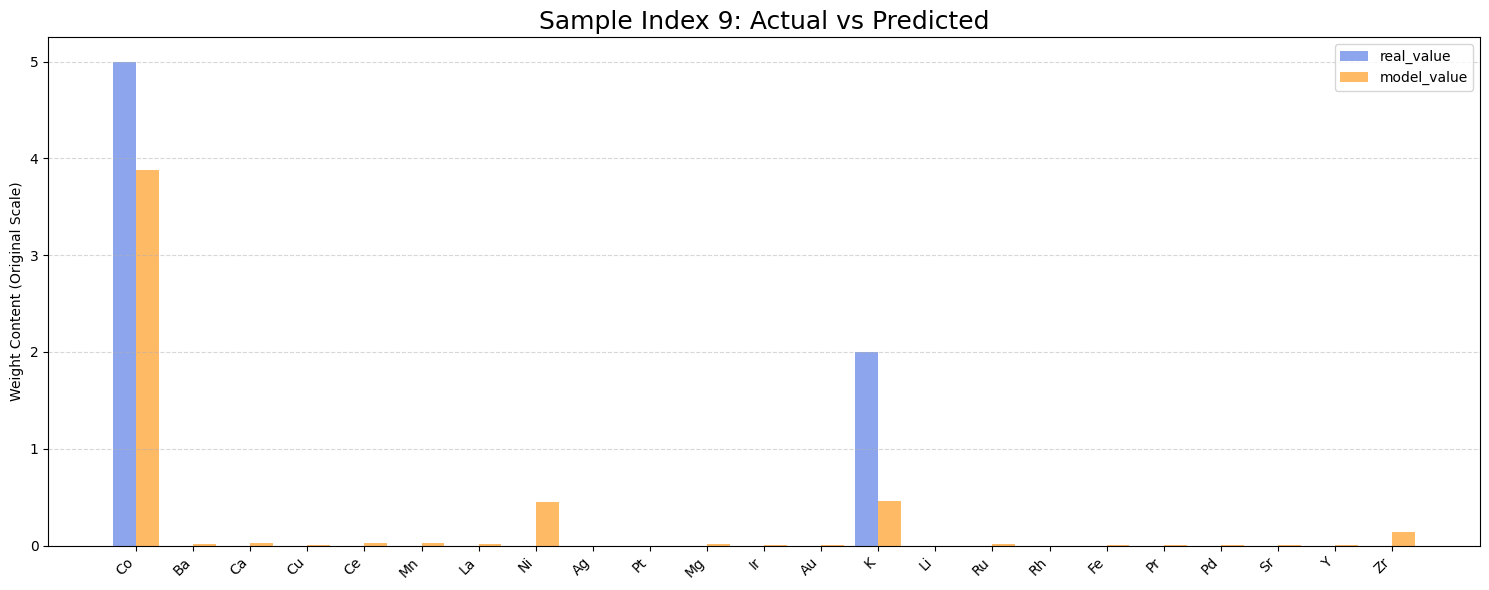

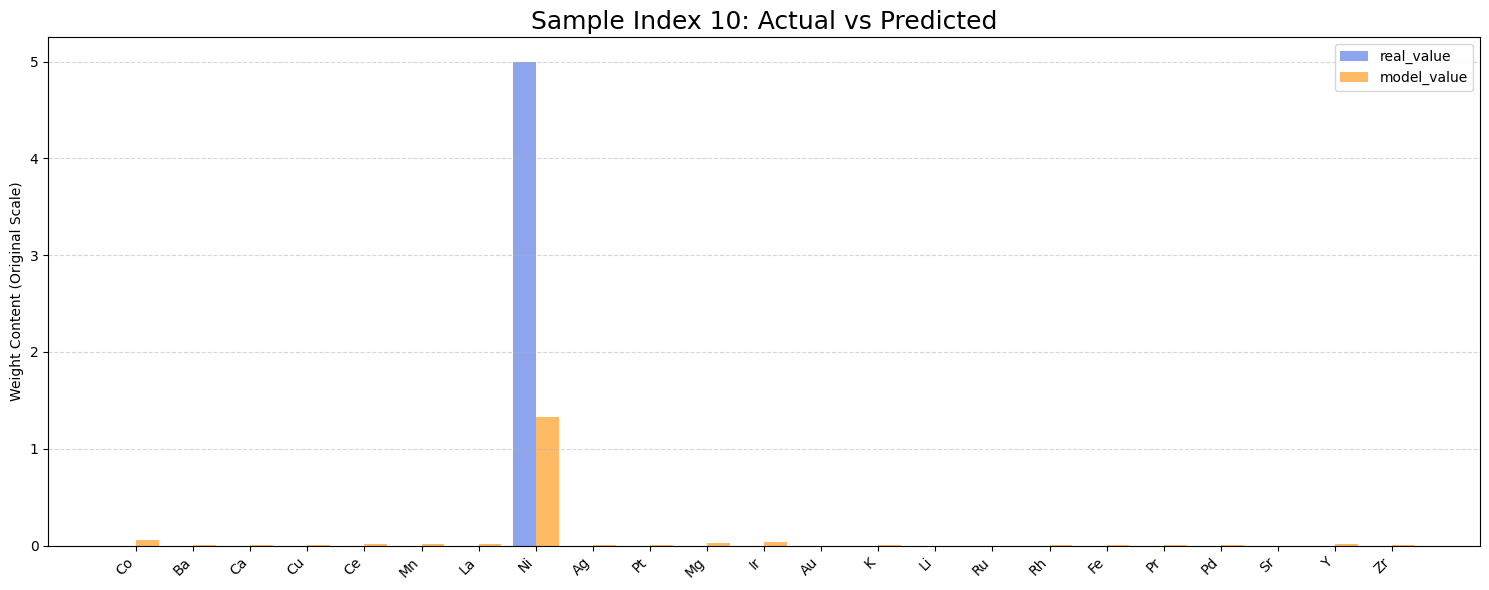

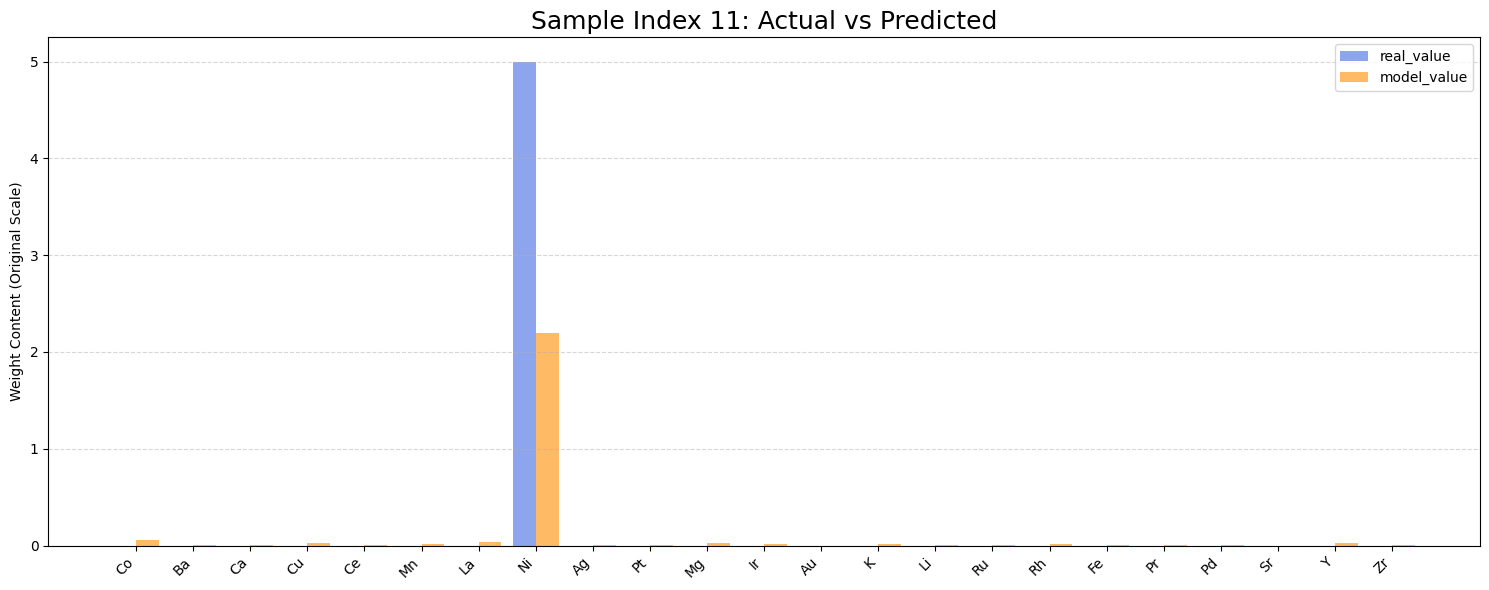

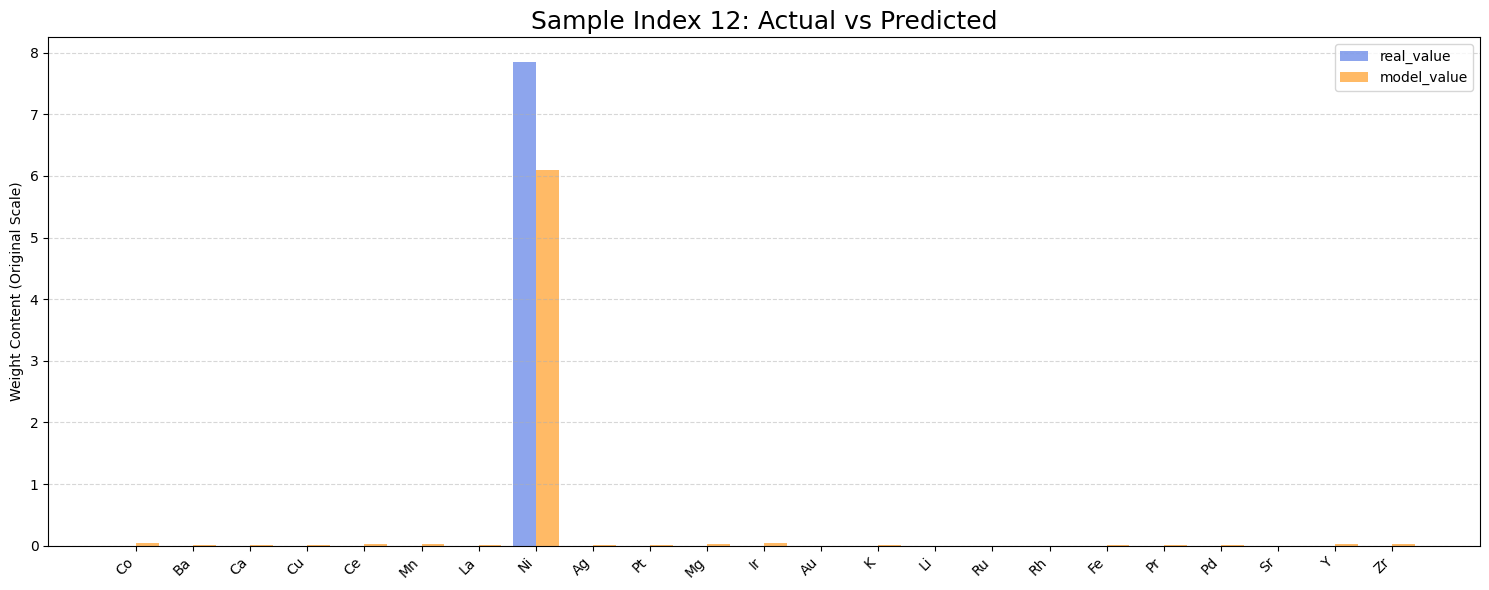

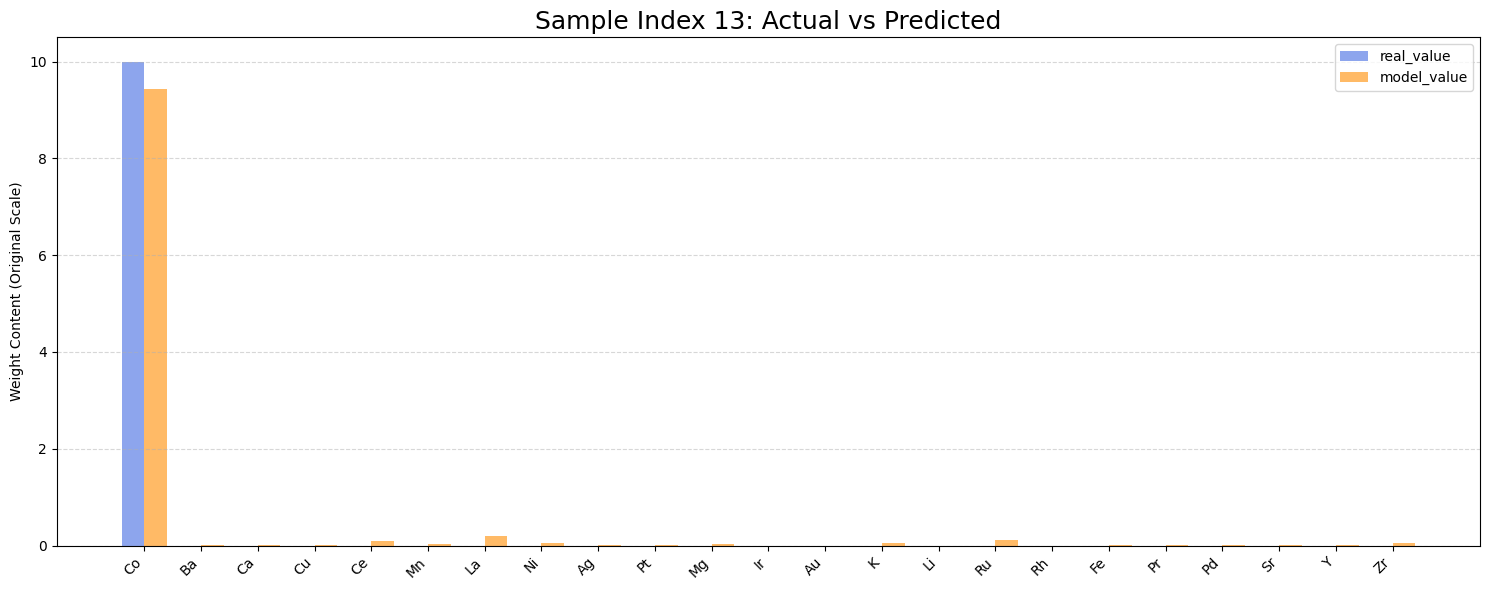

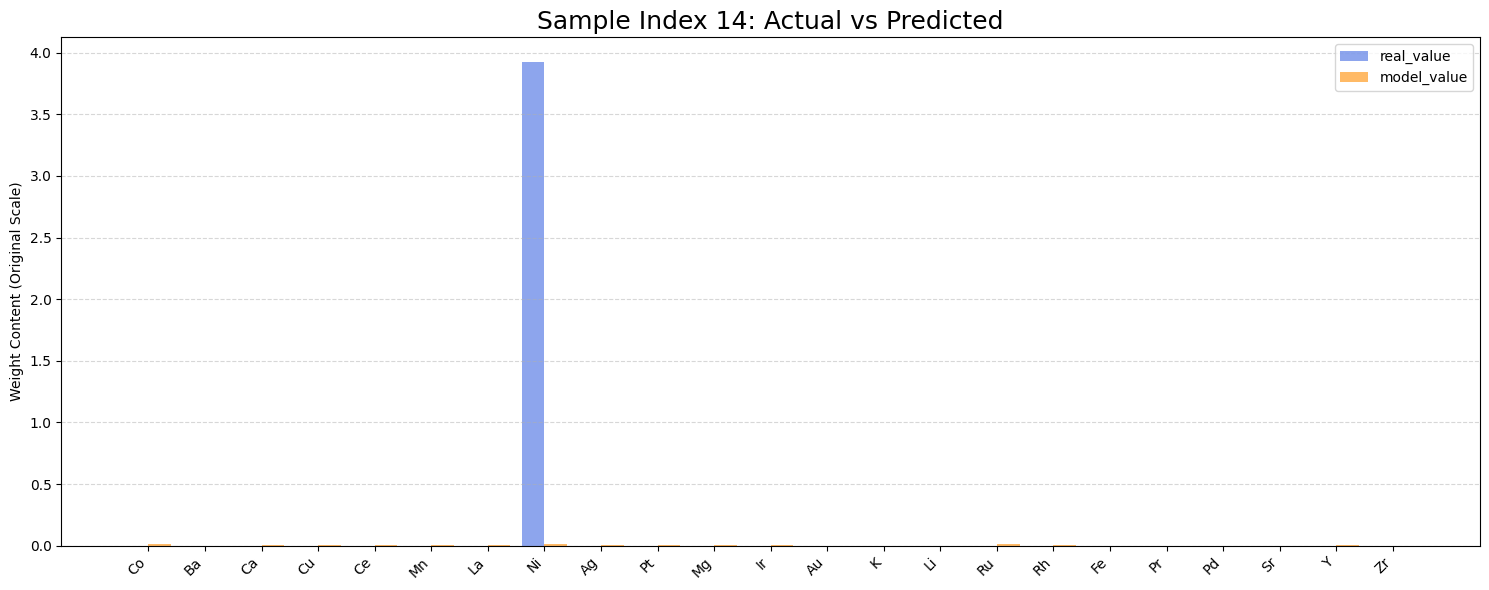


Final RMSE: 0.7362
Final R2: 0.8162


In [ ]:
import numpy as np
import torch
import joblib
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score

# 1) 스케일러 및 컬럼명 로드
x_scaler = joblib.load('./torch/x_scaler.pkl')
df_meta = pd.read_csv('211210-DRM-total.csv')
metal_columns = df_meta.iloc[:, 2:25].columns

# 2) 모델 추론 및 2차원 데이터 수집
model.eval()
x_true_raw_list = []
x_hat_raw_list = []

with torch.no_grad():
    for x_t, c_t in test_loader:
        x_t, c_t = x_t.to(device), c_t.to(device)
        
        # 모델 출력 (StandardScaler가 적용된 도메인의 예측값)
        p_logits, mu_log, logvar_log, _, _ = model(x_t, c_t)
        prob = torch.sigmoid(p_logits).cpu().numpy()
        
        # [핵심] StandardScaler 도메인에서의 기댓값 복원
        # Hurdle 모델은 내부적으로 로그 도메인(mu)을 다루므로 exp를 통해 스케일링된 함량을 구함
        clamped_var = torch.exp(torch.clamp(logvar_log, min=-7, max=2))
        pred_scaled = torch.exp(mu_log + 0.5 * clamped_var)
        
        # 3) --- 역변환 (StandardScaler Inverse Only) ---
        # 사용자님 요청대로 expm1 없이 inverse_transform만 수행
        pred_raw = x_scaler.inverse_transform(pred_scaled.cpu().numpy())
        actual_raw = x_scaler.inverse_transform(x_t.cpu().numpy())
        
        # Soft Hurdle 적용 (확률 * 복원된 원본 함량)
        x_hat_sample = prob * pred_raw
        
        x_true_raw_list.append(actual_raw)
        x_hat_raw_list.append(x_hat_sample)

# 4) (샘플 수, 금속 수) 형태의 2차원 행렬로 통합
x_true_test = np.concatenate(x_true_raw_list, axis=0)
x_hat_test = np.concatenate(x_hat_raw_list, axis=0)

# 5) 샘플별 성분 비교 시각화 (인덱스 5번 ~ 14번)
for i in range(5, 15):
    plt.figure(figsize=(15, 6))
    x_axis = np.arange(len(metal_columns))
    width = 0.4
    
    # 실제값(Blue) vs 모델예측값(Orange)
    plt.bar(x_axis - width/2, x_true_test[i], width, label='real_value', color='royalblue', alpha=0.6)
    plt.bar(x_axis + width/2, x_hat_test[i], width, label='model_value', color='darkorange', alpha=0.6)
    
    plt.xticks(x_axis, metal_columns, rotation=45, ha='right')
    plt.title(f'Sample Index {i}: Actual vs Predicted', fontsize=18)
    plt.ylabel('Weight Content (Original Scale)')
    plt.legend()
    plt.grid(axis='y', linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()

# 6) 전체 지표 산출
y_true = x_true_test.flatten()
y_pred = x_hat_test.flatten()
print(f"\nFinal RMSE: {np.sqrt(mean_squared_error(y_true, y_pred)):.4f}")
print(f"Final R2: {r2_score(y_true, y_pred):.4f}")